# Week 10 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>

With contributions totally ripped off from Argyro Sasli (UMN) and Die Ding (UMN)

# Where are we headed?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction  -> Principle Component Analysis -> Clustering / Density Estimation / Anomaly Detection -> Supervised Learning -> <b> Deep Learning </b> -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL -> Introduction to Multiprocessing -> Introduction to GPUs -> Unit Testing

# Transformers

Transformers are a type of deep learning model designed for sequence-based tasks such as natural language processing (NLP). They rely on the self-attention mechanism to capture contextual information across long sequences efficiently. Unlike recurrent models, transformers process input data in parallel, making them highly scalable.

## Self-Attention Mechanism
Self-attention is a key component of transformers that allows each token in a sequence to consider all other tokens when generating its contextual representation. This is achieved through the following steps:

1. **Linear Projections**: The input sequence is projected into three representations:
   - **Query (Q)**: Represents what each token is looking for in the sequence.
   - **Key (K)**: Represents what each token has to offer.
   - **Value (V)**: Represents the actual content of each token.

2. **Scaled Dot-Product Attention**: Attention scores are computed by taking the dot product of queries and keys, scaling by $\sqrt{d_k}$, and applying a softmax function to obtain weights:
   $$ S = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) $$
   
3. **Weighted Sum of Values**: The attention weights are applied to the values to generate context-aware representations:
   $$ \text{Output} = S V $$

### Importance of Self-Attention
- **Captures Long-Range Dependencies**: Unlike RNNs, which process sequentially, self-attention enables direct interactions between all tokens in a sequence.
- **Parallelization**: Since all tokens attend to each other simultaneously, self-attention allows efficient computation using GPUs.
- **Context Sensitivity**: Each token dynamically adjusts its importance based on the entire sequence, improving understanding of linguistic structures.
- **Multi-Head Attention Enhances Learning**: Using multiple attention heads allows the model to learn different aspects of token relationships.

## Transformer Model Architecture¶
Let us break down the components of the Transformer model, including the embedding layer, transformer blocks, and attention mechanism.

### Input and Output¶
The Transformer class initializes the model parameters and sets up the embedding layer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Optional

class Transformer(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.args = args
        self.vocab_size = args.vocab_size

        # Convert input token indices into dense vector representations
        self.tok_embeddings = nn.Embedding(args.vocab_size, args.dim)

        # Add transformer blocks here
        ...

        # Convert the final hidden state of the model back into a distribution over the vocabulary
        self.output = nn.Linear(args.dim, args.vocab_size, bias=False)

        # Weight Tying: using the same weight matrix to reduce complexity
        self.tok_embeddings.weight = self.output.weight

        # Precompute positional embeddings
        self.freqs_cos, self.freqs_sin = ...

    def forward(self, tokens: torch.Tensor, targets: Optional[torch.Tensor] = None):
        h = self.tok_embeddings(tokens)
        h = self.dropout(h)
        for layer in self.layers:
            h = layer(h, self.freqs_cos[:seqlen], self.freqs_sin[:seqlen])
        h = self.norm(h)

        if targets is not None: # training-stage
            logits = self.output(h)
            self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else: # inference-stage: only select the hidden state of the last token in each sequence
            logits = self.output(h[:, [-1], :])
            self.last_loss = None

        return logits

where ModelArgs contains the following hyperparameters (with the Llama 7B model default):

In [ ]:
from dataclasses import dataclass
@dataclass
class ModelArgs:
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = 32000
    hidden_dim: Optional[int] = None
    multiple_of: int = 256
    norm_eps: float = 1e-5
    max_seq_len: int = 2048
    dropout: float = 0.0

## Transformer Blocks¶
The model contains a series of TransformerBlock layers, each consisting of an attention mechanism and a feed-forward network.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, args: ModelArgs):
        ...
        self.layers = torch.nn.ModuleList()
        for layer_id in range(args.n_layers):
            self.layers.append(TransformerBlock(layer_id, args))
        
        # Normalizes the input to the attention and feed-forward layers.
        self.norm = RMSNorm(args.dim, eps=args.norm_eps)
        ...

class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(dim=args.dim, hidden_dim=args.hidden_dim, multiple_of=args.multiple_of, dropout=args.dropout)
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x, freqs_cos, freqs_sin):
        h = x + self.attention.forward(self.attention_norm(x), freqs_cos, freqs_sin)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out

Unlike **batch normalization**, which normalizes across the batch dimension, **layer normalization** normalizes across the features of each individual token in a sequence. It works independently for each token without relying on the batch statistics. It is applied at every transformer layer to stabilize training by keeping token representations within a consistent range.



The attention mechanism allows the model to weigh different parts of the input sequence differently when producing the token embeddings. This is crucial in capturing context-specific relationships between tokens. Attention mechanisms are used in self-attention for transformers or other forms like cross-attention in encoder-decoder models.

The general formula for a multi-head scaled dot-product attention mechanism on input tensors $Q, K, V \in \mathbb{R}^{\ell \times d_m}$ is defined as follows:

$$
\begin{aligned}
O &=\left(H_1 H_2 \cdots H_h\right) W^O \\
H_i &=S_i V_i^{\prime} \\
S_i &=\operatorname{softmax}\left(\frac{Q_i^{\prime} K_i^{\prime \top}}{\sqrt{d_k}}\right) \\
V_i^{\prime} &=V W_i^V \\
K_i^{\prime} &=K W_i^K \\
Q_i^{\prime} &=Q W_i^Q
\end{aligned}
$$

where:

- $O$ is the output
- $H_i$ is the output of the $i$-th attention head
- $S_i$ is the attention score matrix for the $i$-th head
- $Q_i^{\prime}, K_i^{\prime}, V_i^{\prime}$ are the query, key, value projections for the $i$-th head, respectively
- $\ell$ (seq_len) is the max sequence length
- $d_m$ (dim) is the model dimension
- $h$ (num_heads) is the number of attention heads
- $d_k$ and $d_v$ (head_dim) are the dimensions of the key and value projections

The projection matrices $W_i^Q, W_i^K \in \mathbb{R}^{d_m \times d_k}$ and $W_i^V \in \mathbb{R}^{d_m \times d_v}$ are learnable parameters. Typically, $d_k = d_v = d_m / h$, meaning the dimensions of the keys and values are set so that the overall dimension is evenly split across the multiple heads.


## Self-Attention

In the self-attention mechanism, $Q, K$, and $V$ are all set to the input $X$. The process can be summarized as follows:

### Linear Projections
The input $X$ is linearly projected into queries ($Q$), keys ($K$), and values ($V$) using the learned matrices $W_i^Q, W_i^K, W_i^V$.

- Input $X$ has shape $(\text{batch\_size}, \text{seq\_len}, \text{dim})$
- After linear projections: $Q, K, V$ have shapes $(\text{batch\_size}, \text{seq\_len}, \text{num\_heads}, \text{head\_dim})$ with $\text{head\_dim} = \text{dim} / \text{num\_heads}$

### Scaled Dot-Product Attention
The dot product of queries and keys is computed, scaled by $\sqrt{d_k}$, and passed through a softmax function to obtain the attention scores.

$$ S = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) $$

- Scores $S$ have shape $(\text{batch\_size}, \text{num\_heads}, \text{seq\_len}, \text{seq\_len})$

### Weighted Sum of Values
The attention scores are used to weigh the values.

- The weighted sum $\text{output} = S V$ results in a tensor with shape $(\text{batch\_size}, \text{num\_heads}, \text{seq\_len}, \text{head\_dim})$

### Concatenate and Project
The outputs from all attention heads are concatenated and linearly projected back to the model dimension $d_m$.

- Final output shape: $(\text{batch\_size}, \text{seq\_len}, \text{dim})$

## Self-attention implementation

In [ ]:
class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        # QKV projections
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)

        # Final projection into the residual stream
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)
      
        # Create a mask for causal attention
        mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
        self.mask = torch.triu(mask, diagonal=1)
        ...

    def forward(self, x: torch.Tensor, freqs_cos: torch.Tensor, freqs_sin: torch.Tensor):
  
        # reorganize dimensions and apply relative positional embeddings to update xq, xk using freqs_cos, freqs_sin
        ...

        scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
        scores = scores + self.mask[:, :, :seqlen, :seqlen] 
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, xv)
        output = self.wo(output)
        return output

Here, we used Causal Masking mask to ensure that the future positions have zero contribution in the weighted sum, which prevents attending to future tokens.

# Model Summary and Example

This model includes code modified from the open-source project at https://github.com/karpathy/llama2.c.
The code is used under the MIT License, available at https://github.com/karpathy/llama2.c/tree/master?tab=MIT-1-ov-file#.

In [ ]:
import math
import inspect
from dataclasses import dataclass
from typing import Any, Optional, Tuple
import torch
import torch.nn.functional as F
from torch import nn

@dataclass
class ModelArgs:
    # default hyperparameters for the Llama 7B model
    dim: int = 4096
    n_layers: int = 32
    n_heads: int = 32
    n_kv_heads: Optional[int] = None
    vocab_size: int = 32000
    hidden_dim: Optional[int] = None
    multiple_of: int = 256  # MLP hidden layer size will be multiple of
    norm_eps: float = 1e-5
    max_seq_len: int = 2048
    dropout: float = 0.0


class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cos = torch.cos(freqs)  # real part
    freqs_sin = torch.sin(freqs)  # imaginary part
    return freqs_cos, freqs_sin

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(shape)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cos: torch.Tensor,
    freqs_sin: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:

    # reshape xq and xk to match the complex representation
    xq_r, xq_i = xq.float().reshape(xq.shape[:-1] + (-1, 2)).unbind(-1)
    xk_r, xk_i = xk.float().reshape(xk.shape[:-1] + (-1, 2)).unbind(-1)

    # reshape freqs_cos and freqs_sin for broadcasting
    freqs_cos = reshape_for_broadcast(freqs_cos, xq_r)
    freqs_sin = reshape_for_broadcast(freqs_sin, xq_r)

    # apply rotation using real numbers
    xq_out_r = xq_r * freqs_cos - xq_i * freqs_sin
    xq_out_i = xq_r * freqs_sin + xq_i * freqs_cos
    xk_out_r = xk_r * freqs_cos - xk_i * freqs_sin
    xk_out_i = xk_r * freqs_sin + xk_i * freqs_cos

    # flatten last two dimensions
    xq_out = torch.stack([xq_out_r, xq_out_i], dim=-1).flatten(3)
    xk_out = torch.stack([xk_out_r, xk_out_i], dim=-1).flatten(3)

    return xq_out.type_as(xq), xk_out.type_as(xk)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

class Attention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        assert args.n_heads % self.n_kv_heads == 0
        model_parallel_size = 1
        self.n_local_heads = args.n_heads // model_parallel_size
        self.n_local_kv_heads = self.n_kv_heads // model_parallel_size
        self.n_rep = self.n_local_heads // self.n_local_kv_heads
        self.head_dim = args.dim // args.n_heads
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)
        self.attn_dropout = nn.Dropout(args.dropout)
        self.resid_dropout = nn.Dropout(args.dropout)
        self.dropout = args.dropout

        # use flash attention or a manual implementation?
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            mask = torch.full((1, 1, args.max_seq_len, args.max_seq_len), float("-inf"))
            mask = torch.triu(mask, diagonal=1)
            self.register_buffer("mask", mask)

    def forward(
        self,
        x: torch.Tensor,
        freqs_cos: torch.Tensor,
        freqs_sin: torch.Tensor,
    ):
        bsz, seqlen, _ = x.shape

        # QKV
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_local_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_local_kv_heads, self.head_dim)

        # RoPE relative positional embeddings
        xq, xk = apply_rotary_emb(xq, xk, freqs_cos, freqs_sin)

        # grouped multiquery attention: expand out keys and values
        xk = repeat_kv(xk, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)
        xv = repeat_kv(xv, self.n_rep)  # (bs, seqlen, n_local_heads, head_dim)

        # make heads into a batch dimension
        xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
        xk = xk.transpose(1, 2)
        xv = xv.transpose(1, 2)

        # flash implementation
        if self.flash:
            output = torch.nn.functional.scaled_dot_product_attention(xq, xk, xv, attn_mask=None, dropout_p=self.dropout if self.training else 0.0, is_causal=True)
        else:
            # manual implementation
            scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
            assert hasattr(self, 'mask')
            scores = scores + self.mask[:, :, :seqlen, :seqlen]   # (bs, n_local_heads, seqlen, cache_len + seqlen)
            scores = F.softmax(scores.float(), dim=-1).type_as(xq)
            scores = self.attn_dropout(scores)
            output = torch.matmul(scores, xv)  # (bs, n_local_heads, seqlen, head_dim)

        # restore time as batch dimension and concat heads
        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)

        # final projection into the residual stream
        output = self.wo(output)
        output = self.resid_dropout(output)
        return output


class FeedForward(nn.Module):
    def __init__(self, dim: int, hidden_dim: int, multiple_of: int, dropout: float):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = 4 * dim
            hidden_dim = int(2 * hidden_dim / 3)
            hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    def __init__(self, layer_id: int, args: ModelArgs):
        super().__init__()
        self.n_heads = args.n_heads
        self.dim = args.dim
        self.head_dim = args.dim // args.n_heads
        self.attention = Attention(args)
        self.feed_forward = FeedForward(
            dim=args.dim,
            hidden_dim=args.hidden_dim,
            multiple_of=args.multiple_of,
            dropout=args.dropout,
        )
        self.layer_id = layer_id
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x, freqs_cos, freqs_sin):
        h = x + self.attention.forward(self.attention_norm(x), freqs_cos, freqs_sin)
        out = h + self.feed_forward.forward(self.ffn_norm(h))
        return out


class Transformer(nn.Module):
    last_loss: Optional[torch.Tensor]

    def __init__(self, params: ModelArgs):
        super().__init__()
        self.params = params
        self.vocab_size = params.vocab_size
        self.n_layers = params.n_layers

        # Convert input token indices into dense vector representations
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.dropout = nn.Dropout(params.dropout)

        # A list of TransformerBlock instances, each containing an attention mechanism and a feed-forward network
        self.layers = torch.nn.ModuleList()
        for layer_id in range(params.n_layers):
            self.layers.append(TransformerBlock(layer_id, params))
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)

        # Convert the final hidden state of the model back into a distribution over the vocabulary
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)

        # share the unembedding parameters with the embedding parameters
        self.tok_embeddings.weight = self.output.weight # https://paperswithcode.com/method/weight-tying

        # Precomputed relative positional embeddings using Rotary Position Embedding (RoPE), giving positional info to the model
        freqs_cos, freqs_sin = precompute_freqs_cis(self.params.dim // self.params.n_heads, self.params.max_seq_len)
        self.register_buffer("freqs_cos", freqs_cos, persistent=False)
        self.register_buffer("freqs_sin", freqs_sin, persistent=False)

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('w3.weight') or pn.endswith('wo.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * params.n_layers))

        # Initialize attribute for the loss of the last forward call. This will be set if the forward is called with a targets tensor.
        self.last_loss = None

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, tokens: torch.Tensor, targets: Optional[torch.Tensor] = None) -> torch.Tensor:
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        h = self.dropout(h)
        freqs_cos = self.freqs_cos[:seqlen]
        freqs_sin = self.freqs_sin[:seqlen]

        for layer in self.layers:
            h = layer(h, freqs_cos, freqs_sin)
        h = self.norm(h)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.output(h)
            self.last_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the output on the very last position
            logits = self.output(h[:, [-1], :]) # note: using list [-1] to preserve the time dim
            self.last_loss = None

        return logits

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed (Ridge penalty).
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer


    @torch.inference_mode()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.params.max_seq_len else idx[:, -self.params.max_seq_len:]
            logits = self(idx_cond)
            logits = logits[:, -1, :] # crop to just the final time step
            if temperature == 0.0:
                _, idx_next = torch.topk(logits, k=1, dim=-1)
            else:
                logits = logits / temperature
                if top_k is not None:
                    v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                    logits[logits < v[:, [-1]]] = -float('Inf')
                probs = F.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

As seen above, this model consists of:

### Embedding Layer
- `Embedding(32000, 288)`: Maps input tokens from a vocabulary of 2048 to 288-dimensional embeddings
- `Dropout(p=0.0)`: Applies dropout with a probability of 0.1

### Transformer Blocks (6x)
Each Transformer block contains:

#### Attention Mechanism
- `Linear(in_features=288, out_features=288)`: Four linear transformations (for queries, keys, values, and output) in the multi-head attention mechanism
- `Dropout(p=0.1)`: Two dropout layers for attention and residual dropout

#### FeedForward Network
- `Linear(in_features=288, out_features=768)`: First linear layer
- `Linear(in_features=768, out_features=288)`: Second linear layer that projects back to 288 features
- `Dropout(p=0.1)`: Dropout layer in the feed-forward network

#### Normalization
- `RMSNorm()`: Normalization layer for both the output of the attention block and the feed-forward network

### Final Normalization
- `RMSNorm()`: Normalization layer after the last Transformer block.

### Output Projection
- `Linear(in_features=288, out_features=2048)`: Linear layer that projects the output of the Transformer to a vocabulary size.



# In-class warm-up: Implement a visual transformer

In this exercise, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

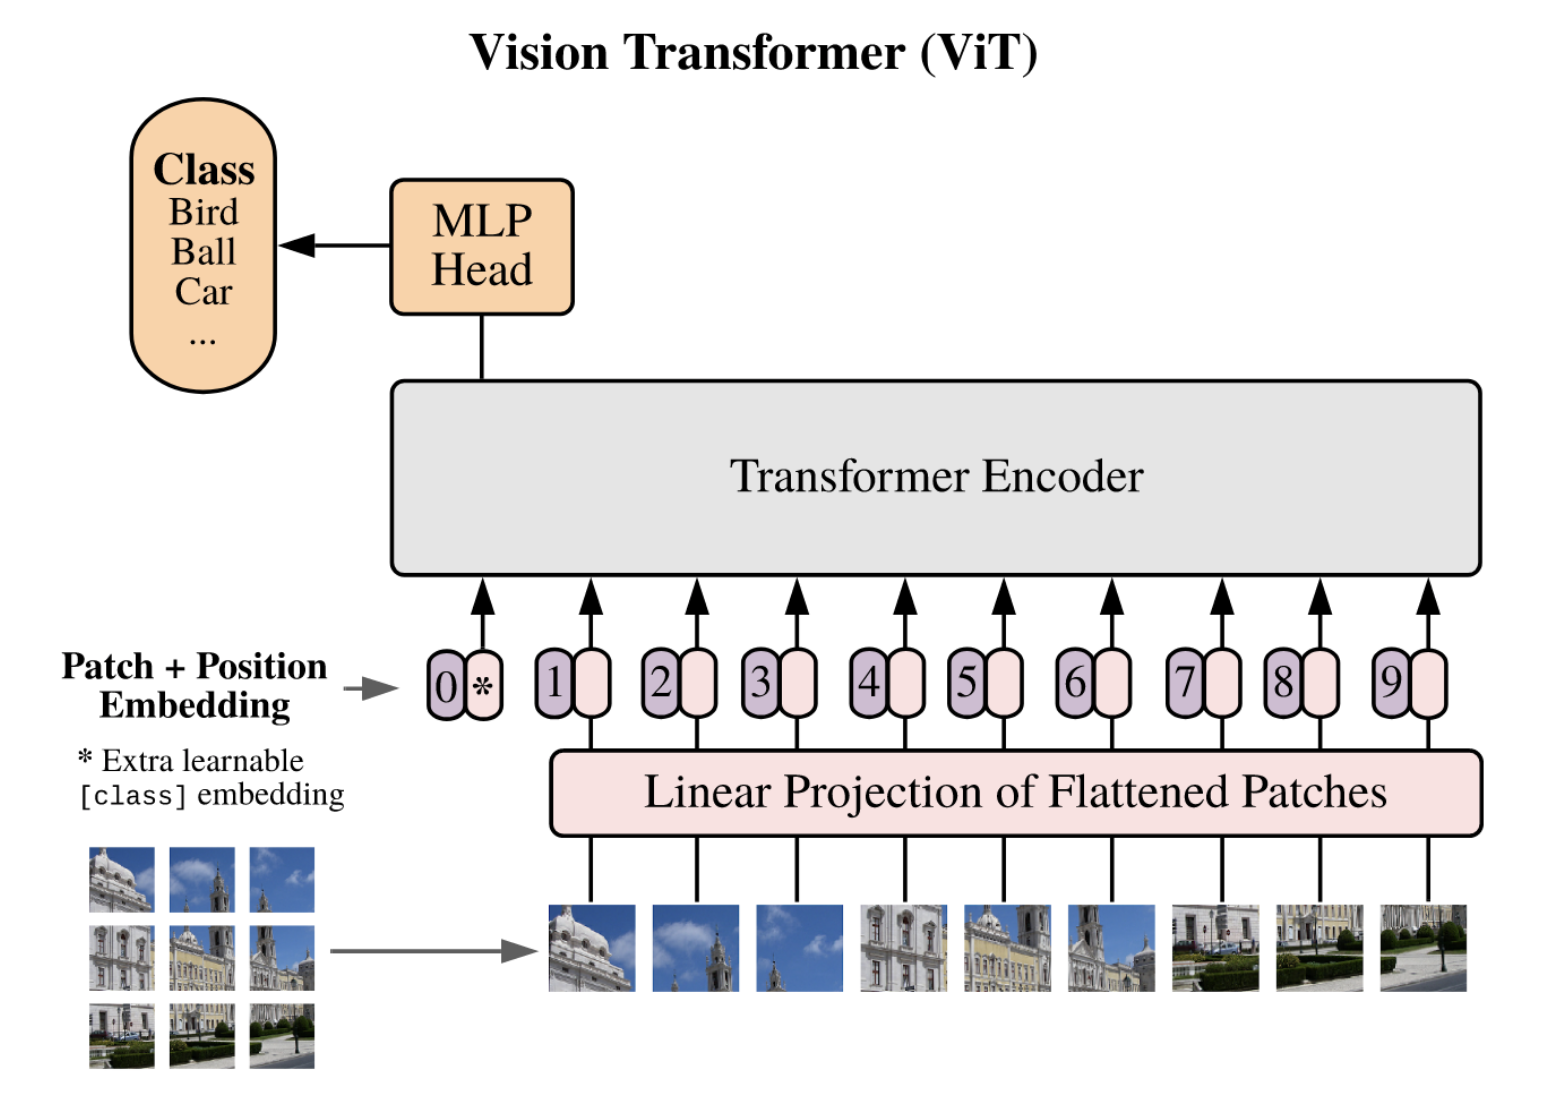

In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.utils import spectral_norm
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

... and visualize!

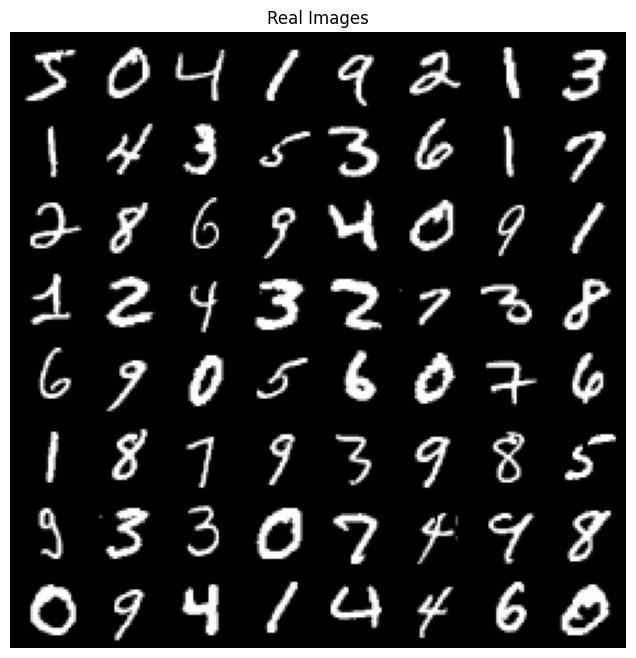

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a 2d convolution (called "Linear Projection" on the image above) to process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    # TODO: do the linear projection
    x = ...
    B, C, H, W = x.shape

    # Reshape appropriately
    x = x.reshape(...
    x = torch.permute(...

    # Shape is now B, N, D
    # With B the batch size
    # With N the number of tokens (N = H * W)
    # With C the embedding dimension

    return x


PatchEmbed()(torch.randn(3, 1, 28, 28)).shape

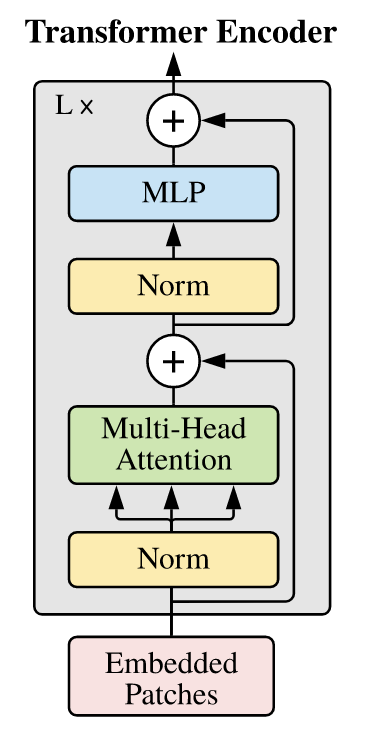

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.layer1 = nn.Linear(...
    self.layer2 = nn.Linear(...
    self.gelu = nn.GELU()

  def forward(self, x):
    x = self.gelu(...
    x = self.gelu(...
    return x


MLP(5, 20)(torch.randn(3, 16, 5)).shape

Now we are going to build the famous **Self-Attention**. At first, we are going to only consider the simple case of one head.

First create the Q / K / V matrices:

$$\begin{array}{c}
Q=X W_{q} \\
K=X W_{k} \\
V=X W_{v}
\end{array}$$

Then, compute the attention:

$$A=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d}}\right)$$

Then multiply it with the Value:

$$Z=AV$$

And don't forget a final linear projection at the end! Good luck!

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()

    self.scale = embed_dim ** -0.5
    self.q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    attention = torch.matmul(...
    attention = torch.softmax(...

    x = torch.matmul(...
    x = self.projection(x)

    return x


SelfAttention(6)(torch.randn(2, 4, 6)).shape

Now, we need to assemble the **Self-Attention** and **MLP** into a Transformer **Block**. Look up the previous image to understand how they are arranged.
Don't forget the *Norm*, which are **LayerNorm**.

In [ ]:
class Block(nn.Module):
  def __init__(self, embed_dim, mlp_ratio=4):
    super().__init__()

    # TODO
    self.multi_head = SelfAttention(embed_dim)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x1 = self.multi_head(...
    x1 = x1 + x

    x2 = self.mlp(...
    x2 = x2 + x1
    return x2

Block(6)(torch.randn(2, 4, 6)).shape

Now, I'm giving you the whole module that combines multiple Blocks together.

Read attentively the forward function and try to understand how the patch embedding, the positional embedding, and the class token are used.

In [ ]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    x = self.patch_embed(x)


    class_token = self.class_token.expand(x.shape[0], -1, -1)

    x = torch.cat((class_token, x), dim=1)
    x = x + self.pos_embed
    x = self.blocks(x)

    x = self.norm(x)
    return self.head(x[:, 0])


ViT(6, 3, 7)(torch.randn(16, 1, 28, 28)).shape

A quick function to evaluate our model:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).to(device).item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [ ]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2


model = ViT(embed_dim, nb_blocks, patch_size).to(device)

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")


Transformers are definitely not made for MNIST, and using a simple MLP or CNN would have done a better job quicker. But that's normal. Transformers really shine when given a tons of data.

The principal is that you know understand better how transformers work, and what is this "attention" that everybody talks about.

If you want to go further, here what you can do:

- Build a **Multi-Heads** Self-Attention (solution given below). The total embedding size will be shared equally among all heads.
- Build a [**CaiT** model](https://arxiv.org/abs/2103.17239) where the class token is only given at the lower blocks, and those lower blocks have a linear complexity w.r.t the number of patch tokens (!!).

In [ ]:
class MultiHeadsSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        head_dim = embed_dim // num_heads
        self.scale = head_dim**-0.5
        self.num_heads = num_heads

        self.q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v = nn.Linear(embed_dim, embed_dim, bias=False)
        self.projection = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, _, N, C = x.shape

        q = self.q(x)
        k = self.k(x)
        v = self.v(x)

        q = q.reshape(B, N, self.num_heads, C // self.num_heads)
        k = k.reshape(B, N, self.num_heads, C // self.num_heads)
        v = v.reshape(B, N, self.num_heads, C // self.num_heads)

        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attention = torch.matmul(q, k.transpose(2, 3)) * self.scale
        attention = torch.softmax(attention, dim=-1)

        x = torch.matmul(attention, v)  # B, H, N, Hd
        x = x.permute(0, 2, 1, 3)
        x = x.reshape(B, N, C)
        x = self.projection(x)

        return x


MultiHeadsSelfAttention(28, 2)(x.to(device)).shape

# In-class Exercise: Transformers for GW Anomaly Detection

In this exercise, we search for anomalies in gravitational-wave data following an unsupervised training approach. The network is trained using only background noise, and we expect it to identify anomalies when exposed to signals like BBHs.  

Download the data [here](https://drive.google.com/file/d/1qR9ZubaQFzdVOEZaQhKhhyXlLDbgXwsG/view?usp=sharing)

The output is the reconstructed time series. When using the network, low errors indicate background noise, while high errors suggest an anomaly.

Further ideas to try:
- You can try training another transformer to reconstruct BBHs.  
- Alternatively, you can train the model using both background noise and BBHs with labels (e.g., `bg: 0`, `bbh: 1`). In this way, you perform supervised learning.


The network is as follows:

**num_heads**: Multi-head attention allows the model to learn different types of patterns in the data.  
  - **Small dataset (<100k samples)**: Start with `num_heads = 4`.  
  - **Medium dataset (100k–1M samples)**: Start with `num_heads = 8`.  

| `num_heads` | Model Complexity | Best For |
|------------|------------------|----------|
| **1-2**  | Low | Simple datasets |
| **4**  | Moderate | Standard tasks |
| **8+**  | High | Large datasets, complex signals |

**ff_dim**: The feedforward dimension in a Transformer model controls the size of the hidden layer inside the feedforward network (FFN) that follows the multi-head self-attention layer. It directly affects model capacity, expressiveness, and computational cost.

**embed_dim**: Transformer hidden size. A higher value means greater feature capacity, allowing the model to learn more complex relationships in the data.

| `embed_dim` | Model Complexity | Best For |
|-------------|------------------|----------|
| **32-64**  | Low | Small datasets, simple patterns |
| **128**  | Moderate | Standard NLP/Time Series tasks |
| **256+**  | High | Large-scale datasets, complex patterns |

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Define Transformer Autoencoder
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerAutoencoder, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(embed_dim, input_dim)  # Reconstruct input

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim) for Transformer

        encoded = self.encoder(x)
        decoded = self.decoder(encoded, encoded)  # Decoder takes encoded representation

        decoded = decoded.permute(1, 0, 2)  # Back to (batch_size, seq_len, embed_dim)
        return self.output_layer(decoded)  # Reconstruct input

# Hyperparameters
input_dim = 2  # Features per time step (H1, L1 data)
embed_dim = 32#64
num_heads = 4
ff_dim = 64 #128
num_layers = 2#3
lr = 0.001
epochs = 30
batch_size = 256#512

In [11]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [12]:
# Split dataset
x_train, x_temp, y_train, y_temp = train_test_split(background, background, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
print(f'x train/val/test shapes: {x_train.shape} {x_val.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')
# Convert to PyTorch tensors
X_train, X_val, X_test = torch.tensor(x_train), torch.tensor(x_val), torch.tensor(x_test)
y_train, y_val, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_val, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)


x train/val/test shapes: (60000, 200, 2) (20000, 200, 2) (20000, 200, 2)
y train/test shapes: (60000, 200, 2) (20000, 200, 2)


In [13]:
# DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize model, loss, optimizer
model = TransformerAutoencoder(input_dim, embed_dim, num_heads, ff_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t:
        for batch_x, in t:
            batch_x = batch_x.to(device).float()
            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"):
                outputs = model(batch_x)
                loss = criterion(outputs, batch_x)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            epoch_loss += loss.item()
            t.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}")

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        with tqdm(X_val.split(batch_size), desc=f"Validation {epoch+1}/{epochs}", unit="batch") as t:
            for val_batch_x in t:
                val_batch_x = val_batch_x.to(device).float()
                with torch.amp.autocast(device_type="cuda"):
                    val_outputs = model(val_batch_x)
                    val_loss += criterion(val_outputs, val_batch_x).item()
                t.set_postfix(val_loss=val_loss / (len(X_val) // batch_size))

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss / (len(X_val) // batch_size):.4f}")

Let's test it!

In [ ]:
# Add only the first 20000 samples of bbhs to X_test
bbh_tensor = torch.tensor(bbh[:20000], dtype=torch.float64)
true_labels = np.concatenate((np.zeros(X_test.shape[0]), np.ones(bbh_tensor.shape[0])))
X_test = torch.cat((X_test, bbh_tensor), dim=0)
y_test = torch.cat((y_test, bbh_tensor), dim=0)

model.eval()
with torch.no_grad():
    batch_test = X_test.to(device).float()
    outputs = model(batch_test)

# Compute Reconstruction Errors (MSE per sample)
reconstruction_errors = torch.mean((outputs - batch_test) ** 2, dim=(1, 2)).cpu().numpy()

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Transformer Autoencoder")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for Anomaly Detection: {optimal_threshold:.4f}")

# Classify anomalies
predictions = (reconstruction_errors > optimal_threshold).astype(int)

# Compute accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")